In [3]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from datetime import datetime
import noisereduce as nr
import soundfile as sf
from scipy.io import wavfile

Loading the wav file with eating signals

In [19]:
def loading_file(audio_path, csv_path):
    # Path to the wav file
    print('Loading audio file')
    sr, y = wavfile.read(audio_path)  # Read the audio file
    print('Finish loading audio file')

    # Path to the csv file
    print('Loading csv file')
    csv_df = pd.read_csv(csv_path)
    csv_df['StartTime'] = pd.to_datetime(csv_df['StartTime'])
    print('Finish loading csv file')

    channel_list = [y[:,i] for i in range(y.shape[1])]
    
    return y, sr, csv_df, channel_list

In [6]:
def wav_real_time(path,csv_df):
    x_axis_time = []
    file_name = path[-15:]

    matching_row = csv_df[csv_df['FileName']==file_name]
    start_time = matching_row['StartTime'].dt.strftime("%Y-%m-%d %H:%M:%S").iloc[0]
    end_matching_row = csv_df.iloc[matching_row.index+1]
    end_time = end_matching_row['StartTime'].dt.strftime("%Y-%m-%d %H:%M:%S").iloc[0]
    start_time = pd.to_datetime(start_time, format="%Y-%m-%d %H:%M:%S")
    end_time = pd.to_datetime(end_time, format="%Y-%m-%d %H:%M:%S")

    x_axis_time.extend([start_time,end_time])
    return x_axis_time[0],x_axis_time[1]

In [6]:
def plot_row_audio(y, sr, start_time, end_time, start_min=0, end_min=None):
    # Convert start_time to datetime
    start_time = pd.to_datetime(start_time)

    # Calculate total duration
    duration = librosa.get_duration(y=y, sr=sr)

    # Calculate sample indices for the specified range
    start_sample = int(start_min * 60 * sr)  # Convert start_min to samples
    end_sample = int(end_min * 60 * sr) if end_min is not None else len(y)  # Convert end_min to samples or default to full length

    # Extract the segment of the signal
    y_segment = y[start_sample:end_sample]

    # Calculate the time axis for the segment
    segment_duration = librosa.get_duration(y=y_segment, sr=sr)
    time_axis_segment = np.linspace(start_min, start_min + segment_duration / 60, len(y_segment))

    # Generate datetime labels for the x-axis
    segment_start_time = start_time + pd.to_timedelta(start_min, unit="m")
    segment_end_time = segment_start_time + pd.to_timedelta(segment_duration / 60, unit="m")
    time_labels = pd.date_range(start=segment_start_time, end=segment_end_time, periods=6)  # 6 evenly spaced labels

    # Plot the segment
    print('Start Plotting')
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis_segment, y_segment, alpha=0.5, label='Signal')
    plt.xticks(np.linspace(start_min, start_min + segment_duration / 60, len(time_labels)),
               time_labels.strftime('%H:%M'), rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Signal from Minute {start_min} to {end_min if end_min else round(duration / 60)} on date {start_time.date()}')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

In [71]:
def plot_spectrogram_or_mel(y, sr, start_time, end_time, start_min=0, end_min=None, cmap='magma', mel=False):
    """
    Plots spectrograms or mel spectrograms for each channel in `y` if it is a dictionary of arrays.

    Parameters:
        y (dict): Dictionary of audio time series, where each key is a channel name and each value is a 1D array.
        sr (int): Sampling rate of the audio.
        start_time (pd.Timestamp): Real-world start time of the audio segment.
        end_time (pd.Timestamp): Real-world end time of the audio segment.
        start_min (int): Start time in minutes relative to the beginning of the audio.
        end_min (int): End time in minutes relative to the beginning of the audio.
        cmap (str): Colormap to use for the spectrogram.
        mel (bool): Whether to plot a mel spectrogram. Default is False.
    """
    

    num_channels = len(y)  # Number of channels

    # Create subplots for multiple channels
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))  # For up to 6 channels, 2 columns and 3 rows
    axes = axes.flatten()

    for idx, (channel_name, channel_data) in enumerate(y.items()):
        # Convert start and end time to sample indices
        start_sample = int(start_min * 60 * sr)
        end_sample = int(end_min * 60 * sr) if end_min is not None else len(channel_data)

        # Ensure start and end are within bounds
        start_sample = max(0, start_sample)
        end_sample = min(len(channel_data), end_sample)

        # Extract audio segment
        y_segment = channel_data[start_sample:end_sample]

        # Compute the spectrogram or mel spectrogram
        if mel:
            S = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_mels=256, fmax=sr)
            S_db = librosa.power_to_db(S, ref=np.max)
        else:
            S = librosa.stft(y_segment)
            S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

        # Generate time axis in real-world format
        segment_duration = librosa.get_duration(y=y_segment, sr=sr)
        segment_start_time = pd.to_datetime(start_time) + pd.to_timedelta(start_min, unit="m")
        segment_end_time = segment_start_time + pd.to_timedelta(segment_duration / 60, unit="m")
        num_minutes = int(segment_duration // 60) + 1
        minute_ticks = np.linspace(0, segment_duration, num=num_minutes)
        time_labels = pd.date_range(start=segment_start_time, periods=num_minutes, freq='min')

        # Plot the spectrogram or mel spectrogram
        ax = axes[idx]
        if mel:
            librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap=cmap, fmax=sr, ax=ax)
            ax.set_ylabel('Frequency (Mel)')
        else:
            frequencies = librosa.fft_frequencies(sr=sr)
            ax.pcolormesh(np.linspace(0, segment_duration, S_db.shape[1]), frequencies, S_db, cmap=cmap)
            ax.set_ylabel('Frequency (Hz)')
        ax.set_title(f'Channel {channel_name[-1:]} Signal on date {start_time.date()}')
        ax.set_xticks(minute_ticks)
        ax.set_xticklabels(time_labels.strftime('%H:%M'), rotation=45)
        ax.set_xlabel('Time')

    # Hide any unused subplots
    for ax in axes[num_channels:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [58]:
'hey'[-1:]

'y'

In [14]:
def reduce_noise(y,sr):
    noise_section = y[:sr]  # First 1 second

    # Reduce noise
    y_reduced_noise = nr.reduce_noise(y=y, sr=sr, y_noise=noise_section)
    
    return y_reduced_noise

# onset + matched filter

In [103]:
st_min = 12
end_min = 13
start_min = sr*60*st_min
end_min = sr*60*end_min

y_bit_signal = y_reduced_noise['y_reduced_noise_1'][start_min:end_min]
y_bit_signal = y_bit_signal / np.max(np.abs(y_bit_signal))

# Option 1: Get onset times directly from the signal
#onset_times = librosa.onset.onset_detect(y=y_bit_signal, sr=sr, units='time')

# Option 2: Use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y=y_bit_signal, sr=sr)  # Compute the onset envelope
times = librosa.times_like(o_env, sr=sr)  # Map onset envelope to time
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)


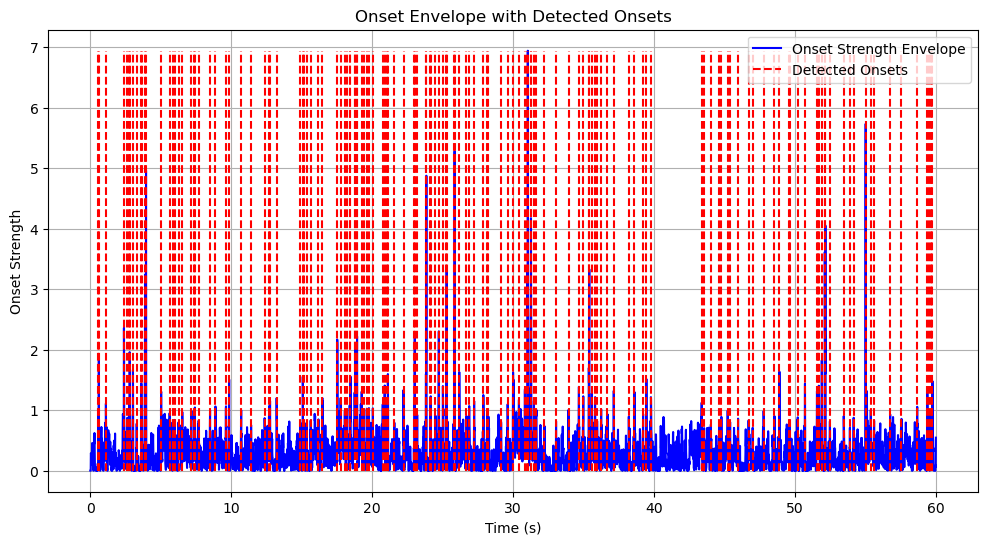

In [104]:
# Plot the onset envelope
plt.figure(figsize=(12, 6))
plt.plot(times, o_env, label='Onset Strength Envelope', color='b')

# Mark the detected onsets
onset_times = librosa.frames_to_time(onset_frames, sr=sr)  # Convert onset frames to times
plt.vlines(onset_times, ymin=0, ymax=max(o_env), color='r', linestyle='--', label='Detected Onsets')

# Add labels and legend
plt.title('Onset Envelope with Detected Onsets')
plt.xlabel('Time (s)')
plt.ylabel('Onset Strength')
plt.legend()
plt.grid(True)
plt.show()

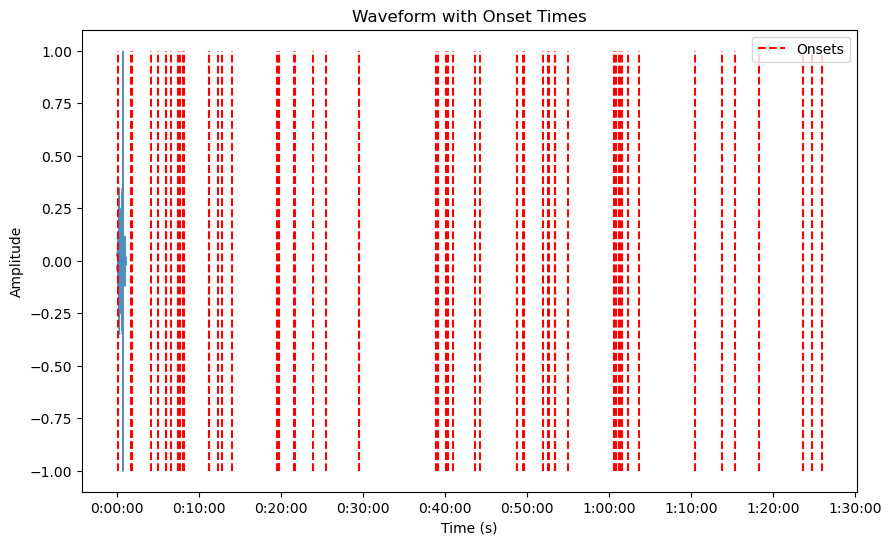

In [97]:
plt.figure(figsize=(10, 6))
librosa.display.waveshow(y_bit_signal, sr=sr, alpha=0.8)
plt.vlines(onset_times, ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')
plt.title('Waveform with Onset Times')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [105]:
# Find unique onset times within each 1-second interval
unique_onsets = []
last_time = None

for time in onset_frames:
    # Check if this is the first or a unique time in the current second
    if last_time is None or (time - last_time) >= 1:
        unique_onsets.append(time)
        last_time = time

# Matched filter graph

## average segmant

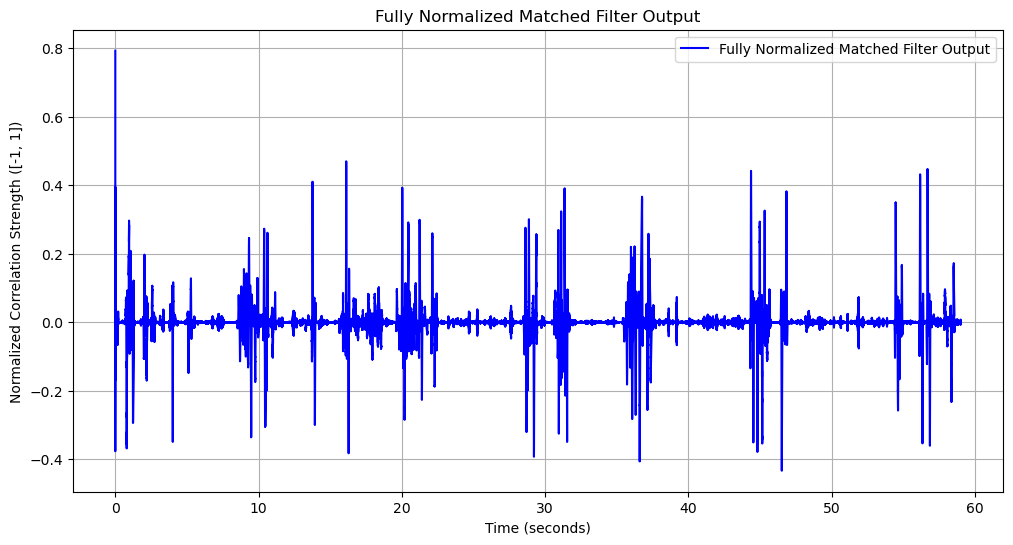

In [ ]:
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt

# Input variables
# sr: sampling rate in Hz
# y_bit_signal: input signal
# unique_onsets: list of onset times (indices in signal)
# window_duration: duration of the window in seconds (e.g., 1 second)

window_duration = 1 # 1-second window
window_size = int(window_duration * sr)  # Convert to samples

# Ensure unique_onsets are integers
unique_onsets = np.array(unique_onsets, dtype=int)

# Extract and create template
segments = []
for onset in unique_onsets:
    start = max(0, onset - window_size // 2)
    end = min(len(y_bit_signal), onset + window_size // 2)
    segment = y_bit_signal[start:end]
    
   # Zero-pad if the segment is shorter than window_size
    if len(segment) < window_size:
        segment = np.pad(segment, (0, window_size - len(segment)), mode='constant')
    
    segments.append(segment)

# Compute the template as the average of all segments
template = np.mean(np.array(segments), axis=0)


# Reverse and conjugate the template
reversed_template = np.conj(template[::-1])

# Apply the matched filter
matched_output = convolve(y_bit_signal, reversed_template, mode='valid')

time_axis = np.arange(len(matched_output)) / sr  # Time in seconds

# Normalize the matched filter output
template_energy = np.sqrt(np.sum(template ** 2))  # Energy of the template
matched_output_normalized = matched_output / template_energy

# Plot the normalized matched filter output
plt.figure(figsize=(12, 6))
plt.plot(time_axis, matched_output_normalized, label='Normalized Matched Filter Output', color='g')
plt.title('Normalized Matched Filter Output')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Correlation Strength')
plt.legend()
plt.grid(True)
plt.show()




# Run the Code

In [120]:
audio_path = r"C:\Users\dror.e\Documents\241103-T013.WAV"
csv_path = r"C:\Users\dror.e\Documents\WAVFileInfo4.csv"

y,sr,csv_df ,channel_list= loading_file(audio_path,csv_path)
start_time, end_time = wav_real_time(audio_path,csv_df)

Loading audio file


C:\Users\dror.e\AppData\Local\Temp\ipykernel_11340\1231823388.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, y = wavfile.read(audio_path)  # Read the audio file


Finish loading audio file
Loading csv file
Finish loading csv file


In [121]:
y_reduced_noise = {}
for i, channel in enumerate(channel_list):
    y_reduced_chanel = reduce_noise(channel, sr)
    y_reduced_noise[f"y_reduced_noise_{i+1}"] = np.asarray(y_reduced_chanel, dtype=np.float32)

c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-

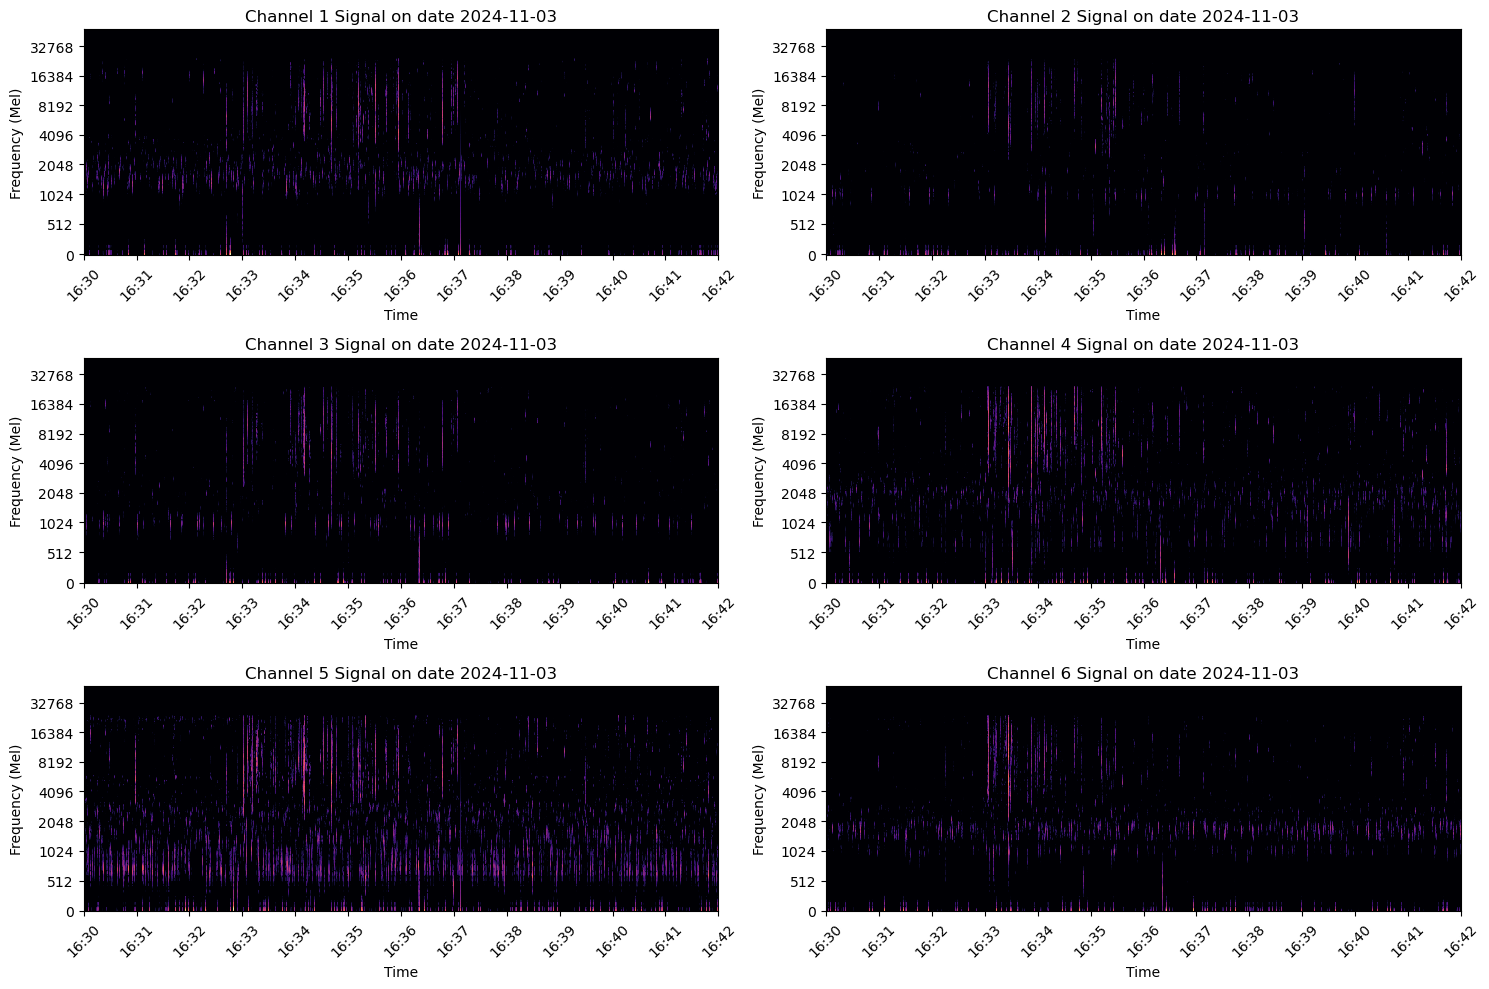

In [122]:
plot_spectrogram_or_mel(y_reduced_noise, sr, start_time, end_time, start_min=6, end_min=18, cmap='magma', mel=True)